In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import neurokit as nk
import seaborn as sns
import pandas as pd
from scipy.interpolate import interp1d
from sklearn import preprocessing, datasets, ensemble, model_selection
from sklearn.ensemble import RandomForestClassifier

In [3]:
data_set_path = r"C:\Users\luiza\Documents\UFSC\TCC_Datasets\WESAD\WESAD"


In [44]:
# Lista para armazenar os dados combinados de todos os diretórios
all_data = []

# Lista de diretórios de S2 a S17
folders = [f"S{i}" for i in range(2, 18)]

for folder_name in folders:
    folder_path = os.path.join(data_set_path, folder_name)

    if os.path.exists(folder_path):
        for folder in os.listdir(folder_path):
            if folder.endswith(".pkl"):
                caminho_arquivo_pkl = os.path.join(folder_path, folder)
                
                # Abrir o arquivo .pkl
                with open(caminho_arquivo_pkl, 'rb') as infile:
                    obj = pickle.load(infile, encoding='latin1')
                    bvp=obj['signal']['wrist']['BVP'][:,0]
                    eda=obj['signal']['wrist']['EDA'][:,0]
                    temp=obj['signal']['wrist']['TEMP'][:,0]
                    label=obj['label']



In [45]:
len(bvp)

378880

In [46]:
len(eda)

23680

In [47]:
len(label)

4144000

In [50]:
fs_label = 700  # Hz
fs_temp_eda = 4  # Hz
fs_bvp = 64  # Hz

len_label = len(label)
len_temp_eda = len(temp)
len_bvp = len(bvp)

total_time = len_label / fs_label

time_label = np.linspace(0, total_time, len_label, endpoint=False)
time_temp_eda = np.linspace(0, total_time, len_temp_eda, endpoint=False)
time_bvp = np.linspace(0, total_time, len_bvp, endpoint=False)


interp_temp = interp1d(time_temp_eda, temp, kind='nearest', fill_value='extrapolate')
interp_eda = interp1d(time_temp_eda, eda, kind='nearest', fill_value='extrapolate')
interp_bvp = interp1d(time_bvp, bvp, kind='nearest', fill_value='extrapolate')

aligned_temp = interp_temp(time_label)
aligned_eda = interp_eda(time_label)
aligned_bvp = interp_bvp(time_label)

In [51]:
hr_data = []
folders = [f"S{i}" for i in range(2, 18)]


for folder_name in folders:
    subfolder_name = f"{folder_name}_E4_Data"
    folder_path = os.path.join(data_set_path, folder_name, subfolder_name)

    if os.path.exists(folder_path):
        csv_path = os.path.join(folder_path, 'HR.csv')
        if os.path.exists(csv_path):
            hr = pd.read_csv(csv_path, skiprows=2, usecols=[0], header=None)
            hr_data.append(hr)

if hr_data:
    combined_hr_df = pd.concat(hr_data, ignore_index=True)
    # Converte para numpy array
    hr = combined_hr_df.iloc[:, 0].to_numpy()

fs_hr = 1  # Hz
len_hr = len(hr)
time_hr = np.linspace(0, total_time, len_hr, endpoint=False)
interp_hr = interp1d(time_hr, hr, kind='nearest', fill_value='extrapolate')
aligned_hr = interp_hr(time_label)

In [52]:
# Criar o array numpy combinando os sinais e os rótulos
numpy_data = np.column_stack((aligned_bvp, aligned_hr, aligned_eda, aligned_temp, label))
                
# Adicionar os dados deste diretório à lista de todos os dados
all_data.append(numpy_data)

# Converter a lista de arrays numpy em um único array numpy
combined_data = np.concatenate(all_data, axis=0)

In [53]:
column_names = ["bvp", "hr", "eda", "temp", "label"]

# Criar DataFrame
df = pd.DataFrame(data=combined_data, columns=column_names)

In [54]:
df

,bvp,hr,eda,temp,label
0,-0.49,101.00,2.015176,33.39,0.0
1,-0.49,101.00,2.015176,33.39,0.0
2,-0.49,101.00,2.015176,33.39,0.0
3,-0.49,101.00,2.015176,33.39,0.0
4,-0.49,101.00,2.015176,33.39,0.0
...,...,...,...,...,...
4143995,-6.21,73.65,0.783331,31.81,0.0
4143996,-6.21,73.65,0.783331,31.81,0.0
4143997,-6.21,73.65,0.783331,31.81,0.0
4143998,-6.21,73.65,0.783331,31.81,0.0


In [55]:
# 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset 
df = df[df['label'] != 7.0]
df= df[df['label'] != 6.0]
df= df[df['label'] != 5.0]
df= df[df['label'] != 0.0]

In [56]:
df

,bvp,hr,eda,temp,label
64564,3.93,76.35,2.082985,33.41,1.0
64565,3.93,76.35,2.082985,33.41,1.0
64566,3.93,76.35,2.082985,33.41,1.0
64567,3.93,76.35,2.082985,33.41,1.0
64568,3.93,76.35,2.082985,33.41,1.0
...,...,...,...,...,...
3957259,-17.04,70.73,0.858816,32.23,4.0
3957260,-17.04,70.73,0.858816,32.23,4.0
3957261,-17.04,70.73,0.858816,32.23,4.0
3957262,-17.04,70.73,0.858816,32.23,4.0


In [57]:
X = df.drop(columns=["label"])  # Remove a coluna "label" para obter os recursos
y = df["label"] # 0 = not defined / transient, 1 = baseline, 2 = stress, 3 = amusement, 4 = meditation, 5/6/7 = should be ignored in this dataset
y = y.astype(int)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

1.0


Temperatura

In [60]:
temp_min = []
temp_max = []
temp_mean = []

for i in range(0, len(df), 3):
    temps = df['temp'].iloc[i:i+3]
    temp_min.append(temps.min())
    temp_max.append(temps.max())
    temp_mean.append(temps.mean())

temp_stats = pd.DataFrame({'temp_min': temp_min, 'temp_max': temp_max, 'temp_mean': temp_mean})

In [61]:
temp_min_array = np.array(temp_stats['temp_min'])
normalized_temp_min = preprocessing.normalize([temp_min_array])
temp_max_array = np.array(temp_stats['temp_max'])
normalized_temp_max = preprocessing.normalize([temp_max_array])
temp_mean_array = np.array(temp_stats['temp_mean'])
normalized_temp_mean = preprocessing.normalize([temp_mean_array])


In [62]:
data_temp = {
    'normalized_temp_mean': normalized_temp_mean.flatten(),
    'normalized_temp_max': normalized_temp_max.flatten(),
    'normalized_temp_min': normalized_temp_min.flatten()
}

df_temp = pd.DataFrame(data_temp)
df_temp.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min
0,0.001215,0.001215,0.001215
1,0.001215,0.001215,0.001215
2,0.001215,0.001215,0.001215
3,0.001215,0.001215,0.001215
4,0.001215,0.001215,0.001215



EDA

In [63]:
eda_min = []
eda_max = []
eda_mean = []
for i in range(0, len(df), 3):
    eda = df['eda'].iloc[i:i+3]
    eda_min.append(eda.min())
    eda_max.append(eda.max())
    eda_mean.append(eda.mean())

eda_stats = pd.DataFrame({'eda_min': eda_min, 'eda_max': eda_max, 'eda_mean': eda_mean})

In [64]:
print(eda_stats.head())

    eda_min   eda_max  eda_mean
0  2.082985  2.082985  2.082985
1  2.082985  2.082985  2.082985
2  2.082985  2.082985  2.082985
3  2.082985  2.082985  2.082985
4  2.082985  2.082985  2.082985


In [65]:
eda_min_array = np.array(eda_stats['eda_min'])
normalized_eda_min = preprocessing.normalize([eda_min_array])
eda_max_array = np.array(eda_stats['eda_max'])
normalized_eda_max = preprocessing.normalize([eda_max_array])
eda_mean_array = np.array(eda_stats['eda_mean'])
normalized_eda_mean = preprocessing.normalize([eda_mean_array])


In [66]:
data_eda = {
    'normalized_eda_mean': normalized_eda_mean.flatten(),
    'normalized_eda_max': normalized_eda_max.flatten(),
    'normalized_eda_min': normalized_eda_min.flatten()
}

df_eda = pd.DataFrame(data_eda)
df_eda.head()

,normalized_eda_mean,normalized_eda_max,normalized_eda_min
0,0.002132,0.002131,0.002132
1,0.002132,0.002131,0.002132
2,0.002132,0.002131,0.002132
3,0.002132,0.002131,0.002132
4,0.002132,0.002131,0.002132


HR


In [67]:
hr_min = []
hr_max = []
hr_mean = []
for i in range(0, len(df), 3):
    hr = df['hr'].iloc[i:i+3]
    hr_min.append(hr.min())
    hr_max.append(hr.max())
    hr_mean.append(hr.mean())

hr_stats = pd.DataFrame({'hr_min': hr_min, 'hr_max': hr_max, 'hr_mean': hr_mean})

hr_min_array = np.array(hr_stats['hr_min'])
normalized_hr_min = preprocessing.normalize([hr_min_array])
hr_max_array = np.array(hr_stats['hr_max'])
normalized_hr_max = preprocessing.normalize([hr_max_array])
hr_mean_array = np.array(hr_stats['hr_mean'])
normalized_hr_mean = preprocessing.normalize([hr_mean_array])

In [68]:
data_hr = {
    'normalized_hr_mean': normalized_hr_mean.flatten(),
    'normalized_hr_max': normalized_hr_max.flatten(),
    'normalized_hr_min': normalized_hr_min.flatten()
}

df_hr = pd.DataFrame(data_hr)
df_hr.head()

,normalized_hr_mean,normalized_hr_max,normalized_hr_min
0,0.001189,0.001189,0.001189
1,0.001189,0.001189,0.001189
2,0.001189,0.001189,0.001189
3,0.001189,0.001189,0.001189
4,0.001189,0.001189,0.001189


In [72]:
df_normalizado = pd.concat([df_temp, df_eda, df_hr], axis=1)
df_normalizado.head()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
0,0.001215,0.001215,0.001215,0.002132,0.002131,0.002132,0.001189,0.001189,0.001189
1,0.001215,0.001215,0.001215,0.002132,0.002131,0.002132,0.001189,0.001189,0.001189
2,0.001215,0.001215,0.001215,0.002132,0.002131,0.002132,0.001189,0.001189,0.001189
3,0.001215,0.001215,0.001215,0.002132,0.002131,0.002132,0.001189,0.001189,0.001189
4,0.001215,0.001215,0.001215,0.002132,0.002131,0.002132,0.001189,0.001189,0.001189


In [73]:
df_normalizado.tail()

,normalized_temp_mean,normalized_temp_max,normalized_temp_min,normalized_eda_mean,normalized_eda_max,normalized_eda_min,normalized_hr_mean,normalized_hr_max,normalized_hr_min
701629,0.001172,0.001172,0.001172,0.000879,0.000879,0.000879,0.001102,0.001102,0.001102
701630,0.001172,0.001172,0.001172,0.000879,0.000879,0.000879,0.001102,0.001102,0.001102
701631,0.001172,0.001172,0.001172,0.000879,0.000879,0.000879,0.001102,0.001102,0.001102
701632,0.001172,0.001172,0.001172,0.000879,0.000879,0.000879,0.001102,0.001102,0.001102
701633,0.001172,0.001172,0.001172,0.000879,0.000879,0.000879,0.001102,0.001102,0.001102


Random Forest

In [74]:
label_mean = []
for i in range(0, len(df), 3):
    label = df['label'].iloc[i:i+3] 
    label_mean.append(label.mean())

label_stats = pd.DataFrame({'label_mean': label_mean})
label_stats.head()

,label_mean
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [75]:
label_stats.tail()

,label_mean
701629,4.0
701630,4.0
701631,4.0
701632,4.0
701633,4.0


In [76]:
train_set = df_normalizado
labels = np.array(label_stats, dtype=int)
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_set, labels, random_state=0)

In [77]:
# acurácia do rf
clf = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9999942990382478

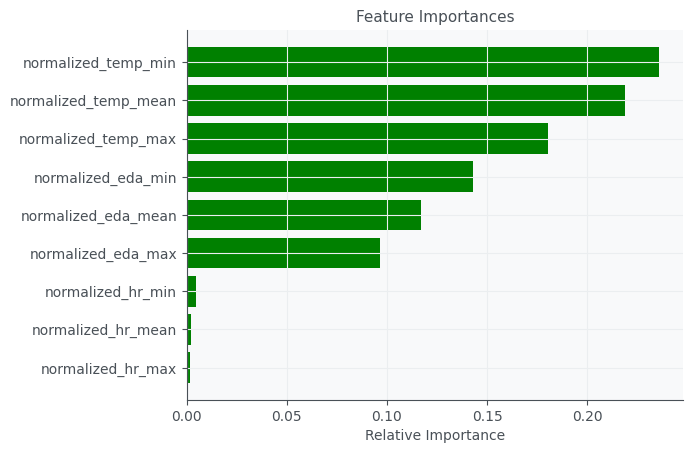

In [78]:
# -- feature importance graph
importances = clf.feature_importances_
indices = np.argsort(importances)
features = train_set.columns
plt.title('Feature Importances')
j = 9   # top j importance
plt.barh(range(j), importances[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Relative Importance')
plt.show()

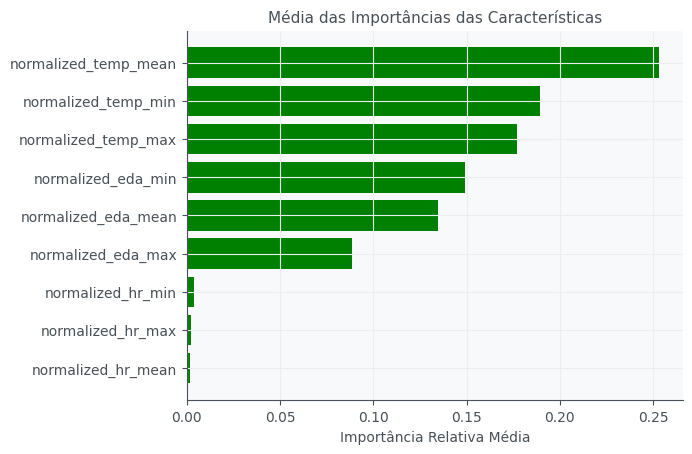

In [79]:
num_execucoes = 100
importancias_medias = np.zeros(X_train.shape[1])  # Lista para armazenar as importâncias médias das características

for _ in range(num_execucoes):
    clf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=None) 
    clf.fit(X_train, y_train.ravel()) 
    
    importancias = clf.feature_importances_
    importancias_medias += importancias

importancias_medias /= num_execucoes # Calcular a média das importâncias das características

indices = np.argsort(importancias_medias)
plt.title('Média das Importâncias das Características')
j = 9   # top j importância
plt.barh(range(j), importancias_medias[indices][len(indices)-j:], color='g', align='center')
plt.yticks(range(j), [features[i] for i in indices[len(indices)-j:]])
plt.xlabel('Importância Relativa Média')
plt.show()